<a href="https://colab.research.google.com/github/justin-g-wang/cs-108-final-project/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Group 20

The goal of our project is to classify whether or not a person earns more than or less than $50,000, depending on the given information. On top of this, when judging the performance of our classifier, fairness is to be evaluated as a metric of high importance. Moreover, experiments involving differential privacy could be used to improve fairness, and robustness for future census releases. Essentially, the data set pulled was compiled using published 1994 census data, before differential privacy or reasonable anonymisation. Hopefully, by mimicking those techniques on non-privatized data, the classifier could be evaluated for how accurate it will be when given privatized data.

The dataset that we will be primarily using for this project is the Census Income dataset provided by UCI (https://archive.ics.uci.edu/dataset/20/census+income). The dataset was extracted from the 1994 Census database and consists of the variables listed below. There are also 48842 instances and 14 features in this dataset.

The data comes in the following format:
- age (integer, none missing)
- workclass (categorical (Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked), some missing)
- finalwgt (skip)
- education (categorical (Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool)), none missing
- marital status (categorical (Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse), none missing)
- occupation (catgorical (Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces), some missing)
- relationship (categorical (Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried), none missing)
- race (categorical (White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black), none missing)
- sex (binary Female, Male. None missing)
- capital-gain (skip)
- capital-loss (skip)
- hours-per-week (integer, none missing)
- native-country (categorical(United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands). Some missing)
- Income (Target variable, binary)

In [ ]:
# preliminary setup
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv("adult.data", index_col=False,
                   names = ['age', 'workclass', 'fwgt', 'education','eduNum','maritalstatus', 'occupation', 'relationship','race', 'sex', 'cg', 'cl','hoursPerWeek', 'nativeCountry',  'income'])

data.head()
data = data[['age', 'workclass', 'education', 'eduNum' , 'maritalstatus', 'occupation', 'relationship', 'race', 'sex', 'hoursPerWeek', 'nativeCountry', 'income']]
data = data.dropna()
data = data[~(data['workclass'] == ' ?')]
data = data[~(data['occupation'] == ' ?')]
data = data[~(data['nativeCountry'] == ' ?')]

print(data.shape)
data.head()

(30162, 12)


,age,workclass,education,eduNum,maritalstatus,occupation,relationship,race,sex,hoursPerWeek,nativeCountry,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K


## Next step: data preprocessing:
To run logistic regression, we should run one-hot-vectors for sex, race, education, workclass, maritalstatus, occupation, relationship, and nativeCountry (change from race = {white, black} to iswhite, isblack)

In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    #https://stackoverflow.com/a/52935270
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(feature_to_encode, axis=1)
    return(res)
converted = data
converted = encode_and_bind(converted, 'workclass')
converted = encode_and_bind(converted, 'education')
converted = encode_and_bind(converted, 'maritalstatus')
converted = encode_and_bind(converted, 'occupation')
converted = encode_and_bind(converted, 'relationship')
converted = encode_and_bind(converted, 'race')
converted = encode_and_bind(converted, 'sex')
converted = encode_and_bind(converted, 'nativeCountry')
converted.rename(columns = lambda x : x.replace(" ",""), inplace = True) #remove spaces from column names
converted['income'] = (converted['income'] != ' <=50K') * 1

print(converted.shape)
print(converted['income'].sum())

converted.head()


#for column in converted.columns:
#    print(column, converted[converted[column] != 0].shape[0])
#converted.loc[converted['nativeCountry_?'] == 1].iloc[0]
#data.iloc[14]['nativeCountry']



(30162, 102)
7508


,age,eduNum,hoursPerWeek,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,nativeCountry_Portugal,nativeCountry_Puerto-Rico,nativeCountry_Scotland,nativeCountry_South,nativeCountry_Taiwan,nativeCountry_Thailand,nativeCountry_Trinadad&Tobago,nativeCountry_United-States,nativeCountry_Vietnam,nativeCountry_Yugoslavia
0,39,13,40,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,13,13,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


small note for future implementations:

- age is numeric
- hoursPerWeek is numeric
- EVREYTHING ELSE IS 1-BIT

## Basic model fitting:

- run a 'fairness through unawareness' model
- run a 'full' model
- run a 'differentially private' model


And test various fairness metrics for it

### Implementing differential privacy

- this is slow
- the results below are intentionally extreme
- the p-value is different in practice

In [ ]:
def addNoise(dataframe, exclude = ['age', 'hoursPerWeek'],p = 0.01): # For bit categorical variables
                                                                      # exclude is hard-written. fix later
    cols = dataframe.shape[1]
    for row in range(dataframe.shape[0]):
        #print(f"row:{row}, ", record)
        noiseMask = (np.random.uniform(low = 0, high = 10, size = cols) < (p * 10))
        #print((noiseMask * 1).sum())
        for col, colname in enumerate(dataframe.columns):
            if((colname not in exclude) and noiseMask[col]): # we switch this
                other = 1 - dataframe.iloc[row, col]
                dataframe.iloc[row, col] = other
            else:
                continue
    return dataframe
test = converted.copy()
addNoise(test.head(), p = 0.5) # noisy intentionally
test.head()

,age,eduNum,hoursPerWeek,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,nativeCountry_Portugal,nativeCountry_Puerto-Rico,nativeCountry_Scotland,nativeCountry_South,nativeCountry_Taiwan,nativeCountry_Thailand,nativeCountry_Trinadad&Tobago,nativeCountry_United-States,nativeCountry_Vietnam,nativeCountry_Yugoslavia
0,39,-12,40,1,0,1,1,1,0,1,...,0,1,0,0,1,0,0,0,0,1
1,50,13,13,1,0,0,0,1,1,1,...,1,1,1,1,0,1,1,0,0,0
2,38,9,40,0,0,0,0,0,1,0,...,1,1,1,0,1,1,1,0,1,0
3,53,7,40,0,1,1,0,0,1,0,...,0,1,0,1,1,0,1,0,0,0
4,28,-12,40,0,0,1,1,1,1,0,...,1,0,1,0,1,1,1,1,0,1


In [ ]:
unawareParams = ['sex', 'race', 'nativeCountry', 'age', 'maritalstatus']
def getGoodCols(dataframe, blindParams):
    ans = []
    for column in dataframe.columns:
        add = True
        for blind in blindParams:
            if(blind in column):
                add = False
        if(add):
            ans.append(column)
    return ans

test = converted.copy()
print("original columns:", test.columns)
goodCols = getGoodCols(test, unawareParams)
print("Good columns:", goodCols)

original columns: Index(['age', 'eduNum', 'hoursPerWeek', 'income', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       ...
       'nativeCountry_Portugal', 'nativeCountry_Puerto-Rico',
       'nativeCountry_Scotland', 'nativeCountry_South', 'nativeCountry_Taiwan',
       'nativeCountry_Thailand', 'nativeCountry_Trinadad&Tobago',
       'nativeCountry_United-States', 'nativeCountry_Vietnam',
       'nativeCountry_Yugoslavia'],
      dtype='object', length=102)
Good columns: ['eduNum', 'hoursPerWeek', 'income', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc', 'workclass_State-gov', 'workclass_Without-pay', 'education_10th', 'education_11th', 'education_12th', 'education_1st-4th', 'education_5th-6th', 'education_7th-8th', 'education_9th', 'education_Assoc-acdm', 'education_Assoc-voc', 'education_Ba

## Putting the new code to use
- Generating the "fairness through unawareness" model (aka blind)
- Generating the noisy model

In [ ]:
fullModel = converted.copy()
unawareModel = converted[getGoodCols(converted.copy(), unawareParams)]
noisyModel = addNoise(converted.copy())  # There are 100ish bits, expected value of flipped bits is 2 per record
                                            # This takes a few seconds

In [ ]:
fullModel.head()

,age,eduNum,hoursPerWeek,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,nativeCountry_Portugal,nativeCountry_Puerto-Rico,nativeCountry_Scotland,nativeCountry_South,nativeCountry_Taiwan,nativeCountry_Thailand,nativeCountry_Trinadad&Tobago,nativeCountry_United-States,nativeCountry_Vietnam,nativeCountry_Yugoslavia
0,39,13,40,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,13,13,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
unawareModel.head()

,eduNum,hoursPerWeek,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,13,40,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,13,13,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,9,40,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7,40,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,13,40,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
noisyModel.head()

,age,eduNum,hoursPerWeek,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,nativeCountry_Portugal,nativeCountry_Puerto-Rico,nativeCountry_Scotland,nativeCountry_South,nativeCountry_Taiwan,nativeCountry_Thailand,nativeCountry_Trinadad&Tobago,nativeCountry_United-States,nativeCountry_Vietnam,nativeCountry_Yugoslavia
0,39,13,40,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,50,13,13,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,7,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,40,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis (EDA)
Below, we did some visualizations to further understand and explore our dataset. First, we did some across different attributes then we did the attributes against income.

<ipython-input-13-de7ed938b444>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x=data['race'], palette='pastel')
<ipython-input-13-de7ed938b444>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[2], x=data['education'], y=data['age'], palette='pastel')


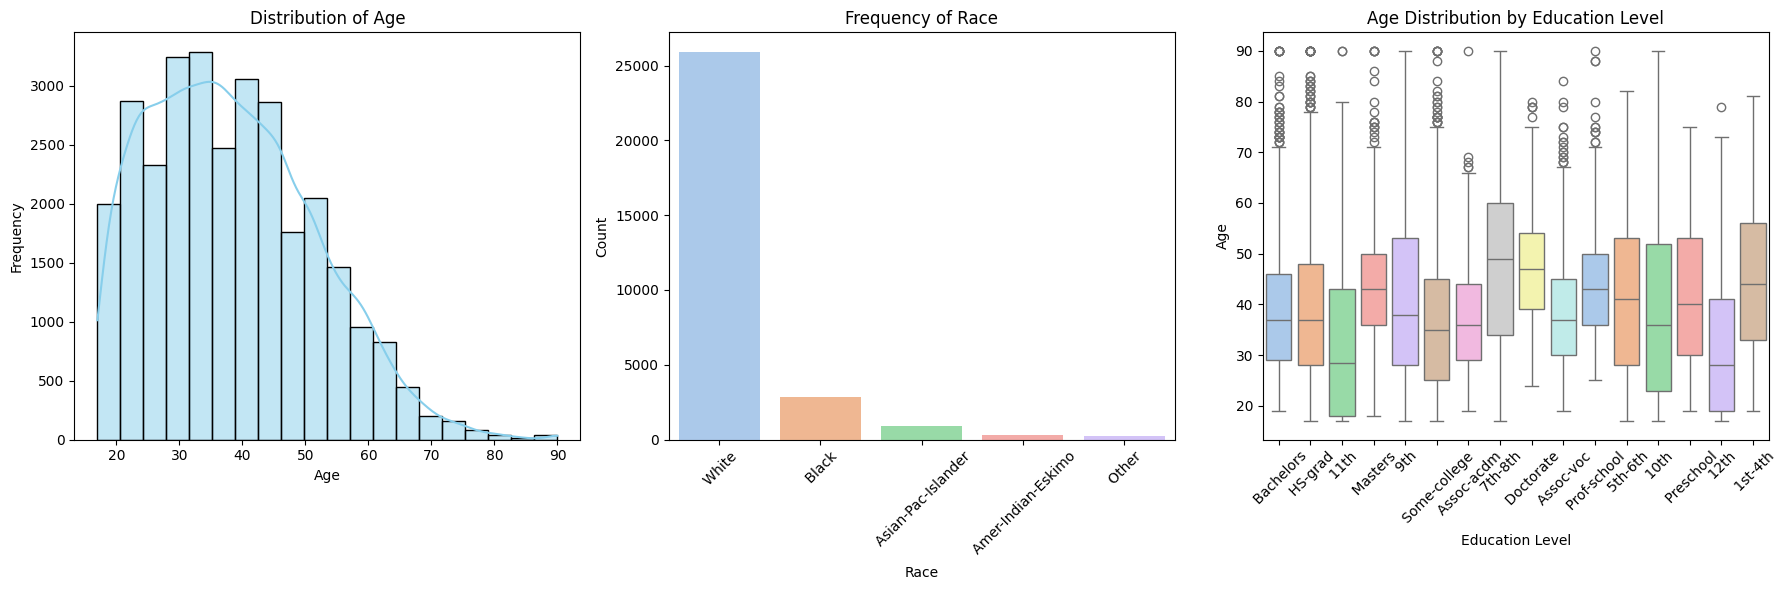

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1
sns.histplot(ax=axes[0], data=data['age'], bins=20, kde=True, color='skyblue')
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot 2
sns.countplot(ax=axes[1], x=data['race'], palette='pastel')
axes[1].set_title('Frequency of Race')
axes[1].set_xlabel('Race')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Plot 3
sns.boxplot(ax=axes[2], x=data['education'], y=data['age'], palette='pastel')
axes[2].set_title('Age Distribution by Education Level')
axes[2].set_xlabel('Education Level')
axes[2].set_ylabel('Age')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Above, for the graph on the left, we created a histogram of the age group that our data is made up of. here we can see that ages 30-35 are the most prominent in our dataset. For the graph in the middle, we made a barchart showcasing the diversity of our data. The census datset predominantly focused on individuals of White ethnicity, with the lowest representation observed among those categorized as "Other." The graph on the right is a box plot of age by education level.


<ipython-input-14-2acd84281136>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', ax=axes[0])
<ipython-input-14-2acd84281136>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[2], x=data['workclass'], palette='pastel')


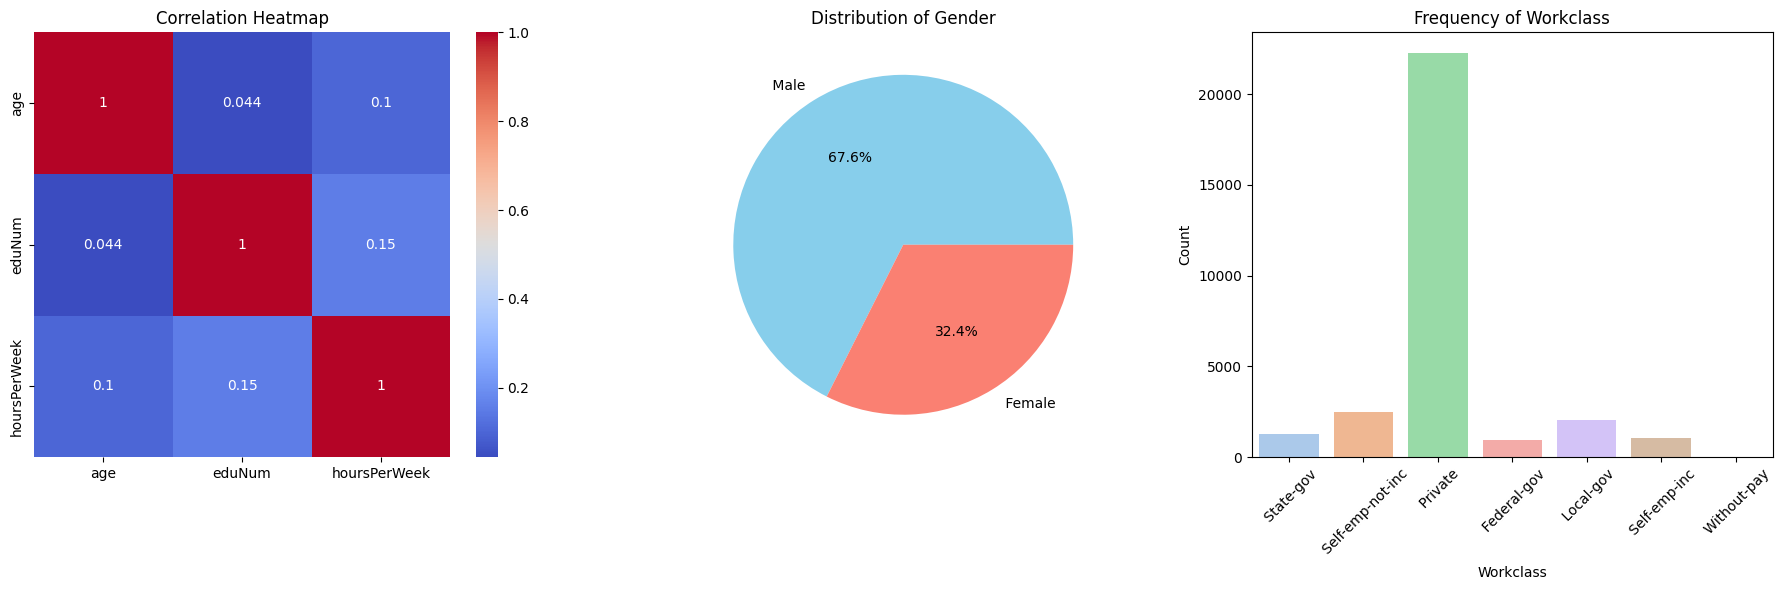

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 4: Correlation Heatmap
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('Correlation Heatmap')

# Plot 5: Pie Chart
data['sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'], ax=axes[1])
axes[1].set_title('Distribution of Gender')
axes[1].set_ylabel('')

# Plot 6: Count Plot
sns.countplot(ax=axes[2], x=data['workclass'], palette='pastel')
axes[2].set_title('Frequency of Workclass')
axes[2].set_xlabel('Workclass')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Above, for the graph on the left, we created a heatmap to see if there was any correlation in our data. The ones with the highest correlation seem to be `eduNum` and `hoursPerWeek`. For the graph in the middle, we generated a pie chart to view the if there were any disparity. We can assume there was since there the data collectd on males is more than twice than the amount for females. The graph on the right is a bar graph displaying the amount of people in each worker class. We can see here that a majority of the individuals in the dataset are employed in the private sector.

<ipython-input-15-fd15c40d30ad>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='income', y='age', data=data, palette='pastel')


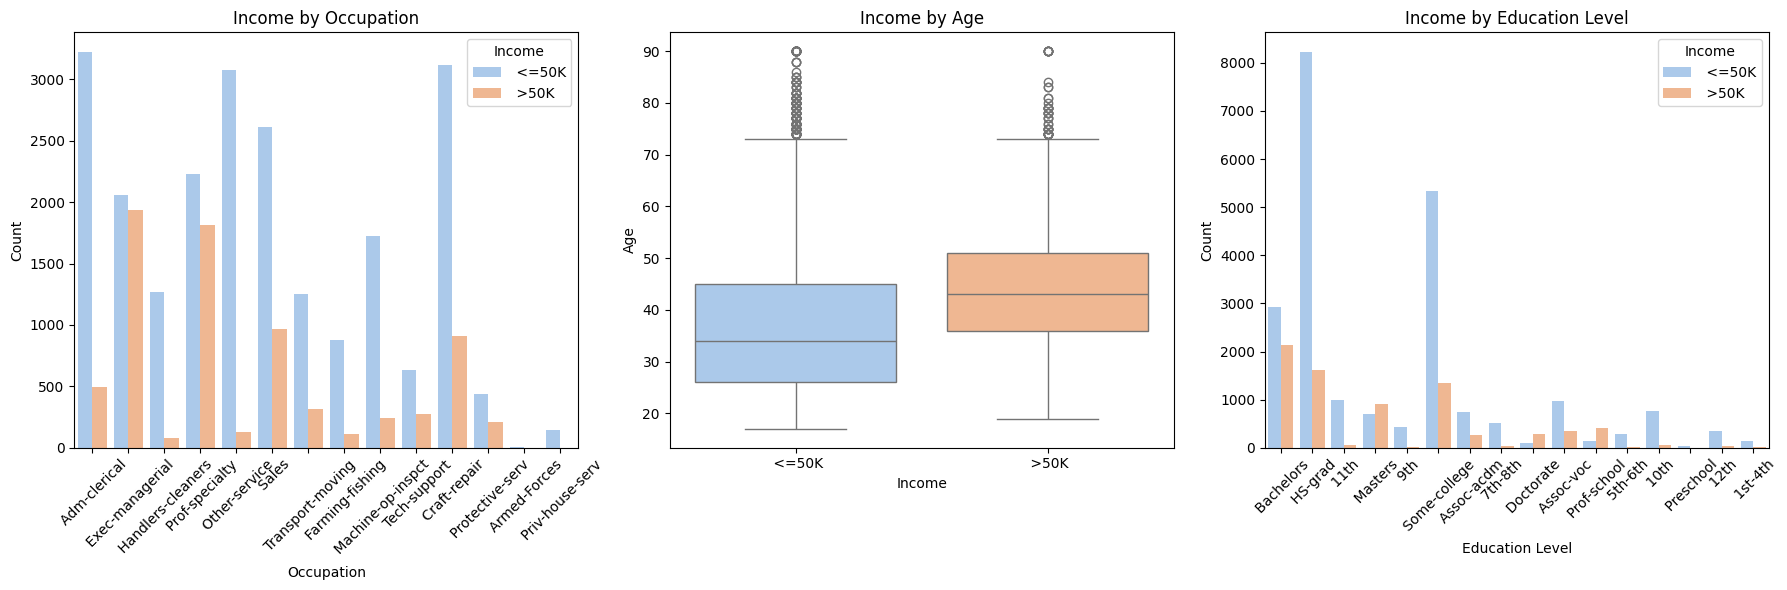

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Bar chart comparing income by occupation
sns.countplot(ax=axes[0], x='occupation', hue='income', data=data, palette='pastel')
axes[0].set_title('Income by Occupation')
axes[0].set_xlabel('Occupation')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Income', loc='upper right')

# Plot 2: Box plot comparing income by age group
sns.boxplot(ax=axes[1], x='income', y='age', data=data, palette='pastel')
axes[1].set_title('Income by Age')
axes[1].set_xlabel('Income')
axes[1].set_ylabel('Age')

# Plot 3: Bar chart comparing income by education level
sns.countplot(ax=axes[2], x='education', hue='income', data=data, palette='pastel')
axes[2].set_title('Income by Education Level')
axes[2].set_xlabel('Education Level')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title='Income', loc='upper right')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

Above, for the graph on the right, we looked at how education level would affect a persons income. We noticed that high school graduates tend to make less than or equal to 50K while those with a bachelors degree make more than 50K compared to others with different education levels. The graph in the middle is a boxplot of age and income. More people have an income <=50K around ages 25-45 compared to those with an income >50K (ages 35-50). For the graph on the left, we looked at how an individual's occupation would affect their income. Here, we can see that a majority of people that work as an administrative clerk have an income of less than or equal to 50k. We can also see that people who's occupation is an executive manager, tend to have an income of more than 50K.


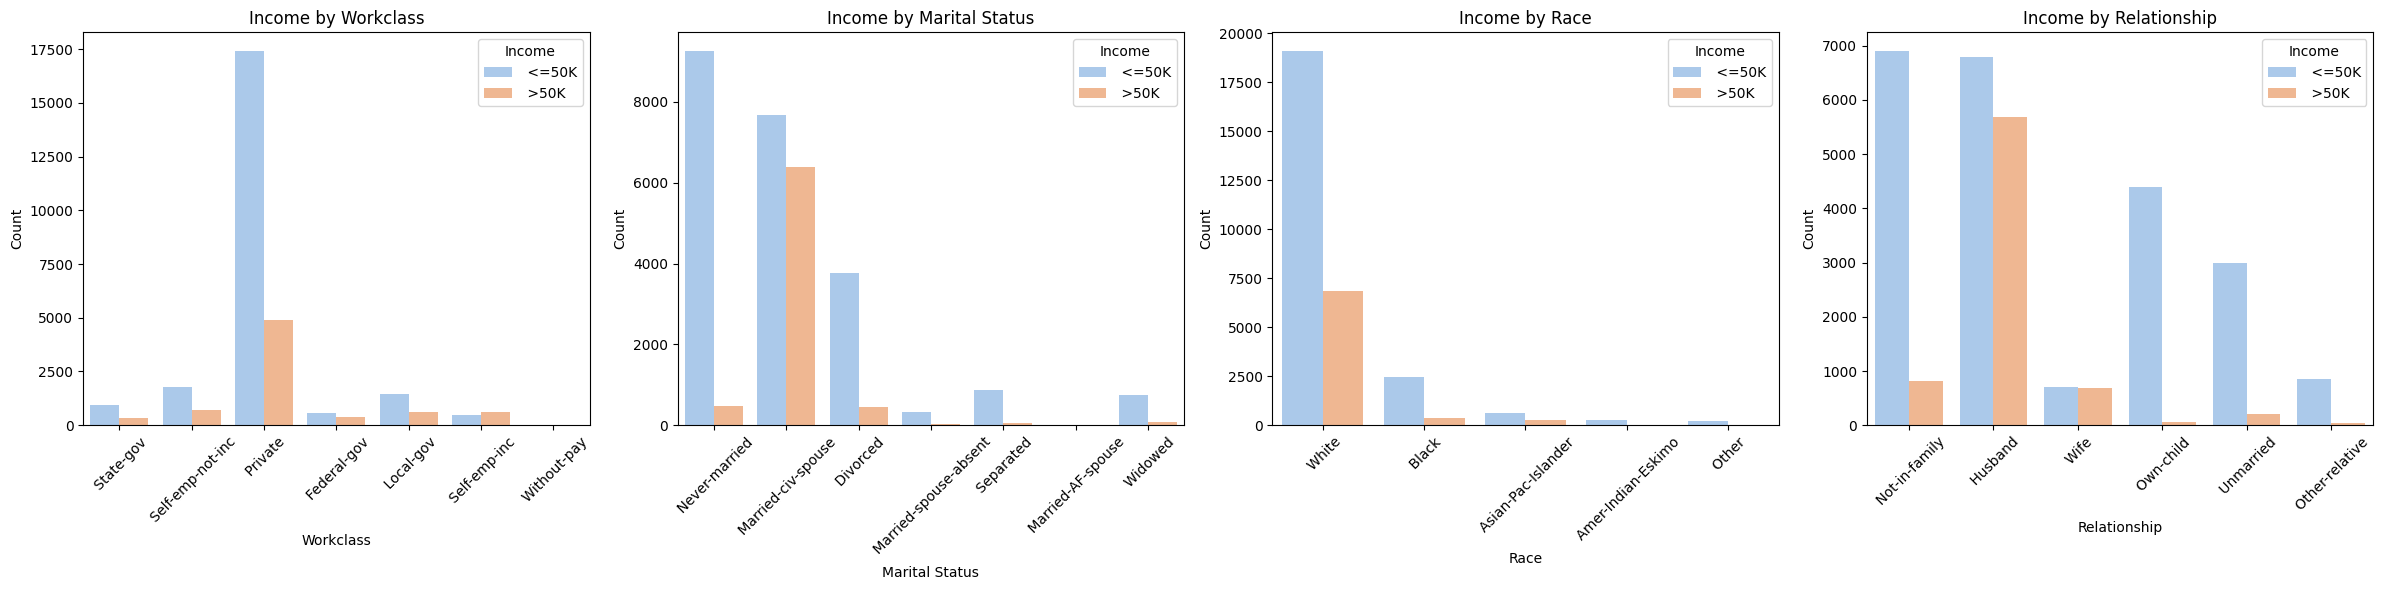

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot 4: Bar chart comparing income by workclass
sns.countplot(ax=axes[0], x='workclass', hue='income', data=data, palette='pastel')
axes[0].set_title('Income by Workclass')
axes[0].set_xlabel('Workclass')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Income', loc='upper right')

# Plot 5: Bar chart comparing income by marital status
sns.countplot(ax=axes[1], x='maritalstatus', hue='income', data=data, palette='pastel')
axes[1].set_title('Income by Marital Status')
axes[1].set_xlabel('Marital Status')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Income', loc='upper right')

# Plot 6: Bar chart comparing income across different races
sns.countplot(ax=axes[2], x='race', hue='income', data=data, palette='pastel')
axes[2].set_title('Income by Race')
axes[2].set_xlabel('Race')
axes[2].set_ylabel('Count')
axes[2].tick_params(axis='x', rotation=45)
axes[2].legend(title='Income', loc='upper right')

# Plot 7: Bar chart comparing income by relationship
sns.countplot(ax=axes[3], x='relationship', hue='income', data=data, palette='pastel')
axes[3].set_title('Income by Relationship')
axes[3].set_xlabel('Relationship')
axes[3].set_ylabel('Count')
axes[3].tick_params(axis='x', rotation=45)
axes[3].legend(title='Income', loc='upper right')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

For the first graph, we created a histogram to see how a peerson's workclass would affect their income. We can see that those that have a private workclass tend to make <=50K. However, some of those that are in that workclass have an income >50K as well. For the second graph, we looked at the how marital status would affect one's income. Here, we can conclude that those that were never married tend to make <=50K while those that most people that have an income >50K are married to a civilian spouse. For the third graph, we looked at how someone's race could affect their income. We can see here that those that identify as White tend to have incomes <=50K. White people also tend to have an income >50K as well compared to the other ethnicities. For the fourth graph, we compared relationship status to income. There were more people that where not in a family that made <=50K and those that had a husband were more likely to have an income >50K.   

## Logistic Regression Model

We decided to build a predictor model to analyze data patterns and make predictions about the future outcomes of our data. We used a Logistic Regression model as our approach to predict if individuals have an income greater than 50K or less than 50K. The target variable (y) is `income`, while the features (x) are othr attributes/characteristics from the census dataset that could influence income levels. This would include `sex`, `race`, `education`, `workclass`, `maritalstatus`, `occupation`, `relationship`, and `nativeCountry`. The model is then trained on these features to predict the binary outcome of whether an individual's income is above or below 50K.

Accuracy: 0.8314271506713078

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4503
           1       0.71      0.56      0.63      1530

    accuracy                           0.83      6033
   macro avg       0.79      0.74      0.76      6033
weighted avg       0.82      0.83      0.82      6033



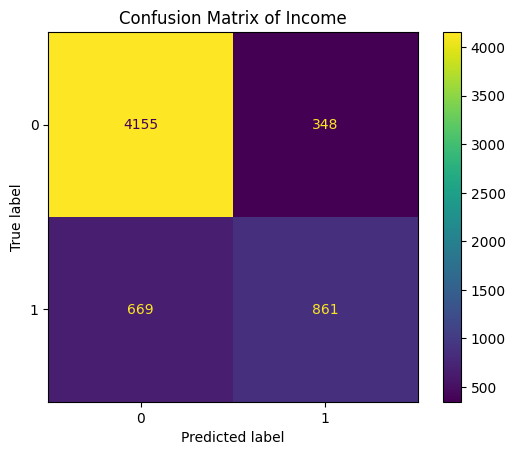

In [ ]:
# Splitting data into features (x) and target variable (y)
x = converted.drop(columns=['income'])
y = converted['income']

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Standardizing features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Creating a logistic regression model
logistic_model = LogisticRegression()

# Fitting the model on the training data
logistic_model.fit(x_train_scaled, y_train)

# Making predictions on the testing data
y_pred = logistic_model.predict(x_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Printing classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Fit the model on the training data
logistic_model.fit(x_train_scaled, y_train)

# Predict labels on the test data
y_pred = logistic_model.predict(x_test_scaled)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
ConfusionMatrixDisplay(conf_matrix).plot()

# Add title to the confusion matrix
plt.title("Confusion Matrix of Income")
plt.show()

Here, we can see that the overall accuracy of the Logistic Regression Model is about 83.14%. This would indicate that it correctly predicts the income status (above or below the 50K threshold) for about 83.14% of the individuals in the dataset. The precision for class 0 (income is <=50K) is 0.86 and for class 1 (income is >50K) is 0.71. The recall for class 0 is 0.92 and for class 1 is 0.56. Due to the low precision and high recall for predicting income below 50K, the model might flag individuals as someone that needs assistance but in reality do not actually require it (high false positive rate). Due to the high precision and low recall for predicting income above 50K, the model may miss identifying individuals who could potentially benefit from certain services or opportunities (high false negative rate). Overall, the model shows reasonably good performance in predicting income levels based on census data attributes. However, the model performs pretty well with high accuracy and precision for incomes that are less than or equal to 50K but lower recall and precision for incomes greater than 50K, which could indicate that the model is better at predicting instances with lower incomes.  







## Analyzing Fairness

In [ ]:
df_fair = data[['race', 'sex', 'income']].copy()

# Define protected features
df_fair['priv_race'] = [1 if race.strip() == 'White' else 0 for race in df_fair['race']]
df_fair['priv_sex'] = [1 if sex.strip() == 'Male' else 0 for sex in df_fair['sex']]

# Encode income as binary (0 for <=50K, 1 for >50K)
df_fair['priv_income'] = [1 if income.strip() == '>50K' else 0 for income in data['income']]

df_fair.head()

,race,sex,income,priv_race,priv_sex,priv_income
0,White,Male,<=50K,1,1,0
1,White,Male,<=50K,1,1,0
2,White,Male,<=50K,1,1,0
3,Black,Male,<=50K,0,1,0
4,Black,Female,<=50K,0,0,0


We created the dataset df_fair to define our protected features which is race and sex. We did this by creating binary variables using the sesntive attributes. In our data, 1 will represent the priviledged group, while 0 will represent the unpriviledged group. For race we defined 'White' as the priviledged group, meaning that those with a value of 1 is white. For sex, we defined 'Male' as the priviledged group. This means that those with a value of 1 under priv_sex are male. We also defined the target variable which is income. If they make more than 50K, then they have a value of 1, else, they have a value of 0 for less than or equal to 50K.

In [ ]:
# Target variable
income = [1 if income.strip() == '>50K' else 0 for income in data['income']]

# Model features
X = data[['age', 'eduNum', 'hoursPerWeek']].copy()
X.loc[:, 'maritalstatus'] = [1 if x.strip() == 'Married-civ-spouse' else 0 for x in data['maritalstatus']]
X.loc[:, 'nativeCountry'] = [1 if x.strip() == 'United-States' else 0 for x in data['nativeCountry']]

# Map occupation groups
occ_groups = {
    'Priv-house-serv': 0, 'Other-service': 0, 'Handlers-cleaners': 0,
    'Farming-fishing': 1, 'Machine-op-inspct': 1, 'Adm-clerical': 1,
    'Transport-moving': 2, 'Craft-repair': 2, 'Sales': 2,
    'Armed-Forces': 3, 'Tech-support': 3, 'Protective-serv': 3,
    'Prof-specialty': 4, 'Exec-managerial': 4
}

X.loc[:, 'occupation'] = [occ_groups[x.strip()] for x in data['occupation']]

X.head()

,age,eduNum,hoursPerWeek,maritalstatus,nativeCountry,occupation
0,39,13,40,0,1,1
1,50,13,13,1,1,4
2,38,9,40,0,1,0
3,53,7,40,1,1,0
4,28,13,40,1,0,4


To look at feature importance, we set our target variable as income. Then we create 6 model features. Initially, we retain age, education-num, and hours-per-week unchanged. Then we transform marital-status and native-country into binary features. Lastly, we categorize the occupation feature by grouping the initial occupations into five distinct groups.

# Feature Importance Analysis (race)


In [ ]:
#Feature importance race

# Get balanced sample

y_race_0 = df_fair[df_fair['priv_race'] == 0]['priv_race']
y_race_1 = df_fair[df_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = y_race_0.append(y_race_1)

X_race = X.loc[y_race.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

#Calculate accuracy
acc_race = accuracy_score(y_race, y_pred)

#Get feature importance
fi_race = model.get_booster().get_score(importance_type='weight')


#Output results
print(acc_race)
print(confusion_matrix(y_race, y_pred))
print(classification_report(y_race, y_pred))

<ipython-input-20-aa949cdb0eaa>:8: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_race = y_race_0.append(y_race_1)


0.7494679593284465
[[3190 1039]
 [1080 3149]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      4229
           1       0.75      0.74      0.75      4229

    accuracy                           0.75      8458
   macro avg       0.75      0.75      0.75      8458
weighted avg       0.75      0.75      0.75      8458



For class 0 (negative class): Of all the instances predicted as negative, 75% were actually negative. Of all the actual negative instances, 76% were correctly predicted as negative.

For class 1 (positive class): Of all the instances predicted as positive, 75% were actually positive.Of all the actual positive instances, 75% were correctly predicted as positive. The 'support' value represents the number of actual occurrences of each class in the dataset.

The overall accuracy of the model is 0.75, which means the model correctly predicted the class 75% of the time for both positive and negative classes. The macro average and weighted average are also both 0.75, which implies a balanced performance across both classes.

However, the presence of 1025 false positives and 1071 false negatives suggests there's room for improvement in the model's predictive capabilities.

# Feature Importance Analysis (sex)

In [ ]:
#Feature importance sex

# Get balanced sample
y_sex_0 = df_fair[df_fair['priv_sex'] == 0]['priv_sex']
y_sex_1 = df_fair[df_fair['priv_sex'] == 1]['priv_sex']
y_sex_1 = y_sex_1.sample(len(y_sex_0))
y_sex = y_sex_0.append(y_sex_1)

X_sex = X.loc[y_sex.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_sex, y_sex)

y_pred = model.predict(X_sex)

#Calculate accuracy
acc_sex = accuracy_score(y_sex, y_pred)

#Get feature importance
fi_sex = model.get_booster().get_score(importance_type='weight')

#Output results
print(acc_sex)
print(confusion_matrix(y_sex, y_pred))
print(classification_report(y_sex, y_pred))

<ipython-input-21-6abf8c939df7>:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y_sex = y_sex_0.append(y_sex_1)


0.8000920057248007
[[8322 1460]
 [2451 7331]]
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      9782
           1       0.83      0.75      0.79      9782

    accuracy                           0.80     19564
   macro avg       0.80      0.80      0.80     19564
weighted avg       0.80      0.80      0.80     19564



For class 0 (negative class): Of all the instances predicted as negative, 77% were actually negative. Of all the actual negative instances, 84% were correctly predicted as negative.

For class 1 (positive class): Of all the instances predicted as positive, 83% were actually positive.Of all the actual positive instances, 75% were correctly predicted as positive.

The overall accuracy of the model is 0.79, which means the model correctly predicted the class 79% of the time for both positive and negative classes.
This means that approximately 79% of the model's predictions are correct. The macro and weighted averages of precision, recall, and F1-score are all approximately 0.79, which suggests that the model's performance is relatively consistent across both classes.


In [ ]:
#Train model
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)
df_fair['y_pred'] = y_pred

print(confusion_matrix(y, y_pred))
print(accuracy_score(y, y_pred))
print(classification_report(y, y_pred))

[[20922  1732]
 [ 2808  4700]]
0.8494794774882303
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     22654
           1       0.73      0.63      0.67      7508

    accuracy                           0.85     30162
   macro avg       0.81      0.77      0.79     30162
weighted avg       0.84      0.85      0.85     30162



We train the model using the features and target variable we defined earlier. We then get the predictions and add them to our df_fair dataset. In the end, this model had an accuracy of 85%. The precision was 73% and the recall was 63% for the priviledged groups and 88% and 92% for the unprivileged groups. In this case, the model performs better on the negative class "0" than on the positive class "1".

Some **ethical considerations** for this model is that the data contains historical biases based on race or sex, the model may make predictions that are unfair to individuals belonging to certain groups. Using sensitive attributes like race and sex directly in the model can lead to discriminatory decision-making. Another consideration is that we split race into two groups. There are more than two races in this dataset.



# Measuring Bias



Text(0.5, 1.0, 'Sex')

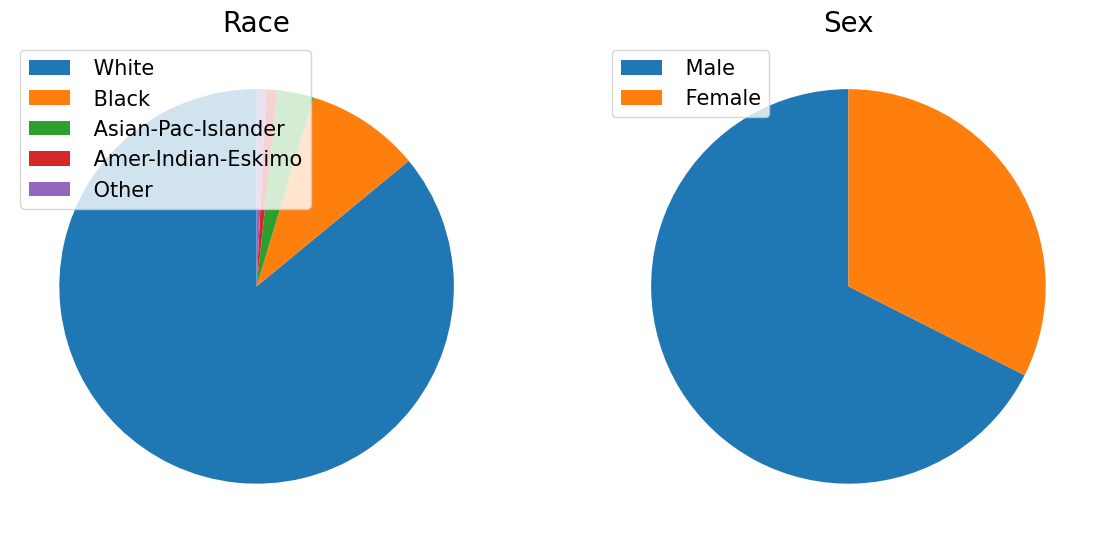

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(121)

#Plot breakdown by race
counts = data['race'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Race",size=20)

plt.subplot(122)

#Plot breakdown by sex
counts = data['sex'].value_counts()
labels = counts.index

plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Sex",size=20)

In order to measure bias, we started off by seeing if our datset was unbalanced. More specifically, we looked at the balance of the sensitive attributes. The pie chart above displays the counts of race and sex. As you can see, the dataset is unbalanced. The first pie chart shows a large majority of the population is white while the second pie chart shows the majority of the population is male.
Why then do we have to see if our dataset if unbalanced? This is because with an unbalanced dataset, the model parameters can be skewed towards the majority. For example, the relationship between the features and the target variable could be different. Models try to maximize accuracy across the entire population, and when they do that with an unbalanced dataset such as this one, it can favor the majority while having lower accuracy for the minority.

In [ ]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""

    #converting to binary integers
    df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})

    #Confusion Matrix


    cm=confusion_matrix(df['income'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()

    N = TP+FP+FN+TN

    # Overall accuracy
    ACC = (TP+TN)/N

    # True positive rate
    TPR = TP/(TP+FN)

    # False positive rate
    FPR = FP/(FP+TN)

    # False negative rate
    FNR = FN/(TP+FN)

    # Percentage predicted as positive
    PPP = (TP + FP)/N

    #negative predictive value
    NPV = TN / (TN + FN)

    #positive predictive value
    PPV = TP / (TP + FP)



    return np.array([ACC, TPR, FPR, FNR, PPP, NPV, PPV])



In the above code, we defined different definitions for fairness. These definitions involved splitting the population into two groups, priviledged and unpriviledged. Specifically, we defined the forumlas for confusion matrix(cm), overall accuracy (ACC), True positive rate(TPR), False Positive rate (FPR), False negative rate (FNR), Percentage predicted as postive (PPP), negative predictive value (NPV), and positive predictive value (PPV). We then display all the values in an array.

In [ ]:
#Calculate fairness metrics for race

print(df_fair.columns)

#df_race_1 = df_fair[df_fair.priv_race == 1].sample(min(df_fair.priv_race.value_counts()))
#df_race_0 = df_fair[df_fair.priv_race == 0]

fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

print(fm_race_1)
print(fm_race_0)
print(fm_race)

Index(['race', 'sex', 'income', 'priv_race', 'priv_sex', 'priv_income',
       'y_pred'],
      dtype='object')
[0.8426715  0.63474192 0.08285325 0.36525808 0.22839625 0.87516242
 0.73290562]
[0.89122724 0.53662182 0.04213483 0.46337818 0.12035942 0.91666667
 0.70530452]
[1.0576212  0.84541734 0.50854771 1.26863225 0.52697635 1.04742462
 0.96234017]


<ipython-input-24-eb9c97b10e91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
<ipython-input-24-eb9c97b10e91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})


We used the function for the race protected feature. We passed subgroups of the population, priviledged race and unprivileged race, to fariness_metrics function. Then we took the ratio of the unpriviledged to priviledge metrics.

In [ ]:
#Calculate fairness metrics for sex
fm_sex_1 = fairness_metrics(df_fair[df_fair.priv_sex==1])
fm_sex_0 = fairness_metrics(df_fair[df_fair.priv_sex==0])


#Get ratio of fairness metrics
fm_sex = fm_sex_0/fm_sex_1

print(fm_sex_1)
print(fm_sex_0)
print(fm_sex)

[0.81378803 0.65306442 0.11270023 0.34693558 0.28228656 0.84829425
 0.72605597]
[0.92383971 0.47032374 0.01799308 0.52967626 0.06941321 0.93529606
 0.77025037]
[1.13523384 0.72017971 0.15965433 1.52672796 0.24589626 1.10256088
 1.06086913]


<ipython-input-24-eb9c97b10e91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})
<ipython-input-24-eb9c97b10e91>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})


We did the same thing with the sex protected feature.

We then isolate thee PPV and NPV and compare the primary attributes to the other attributes to determine if there are any discrepancies in fairness.

In [ ]:
#1 is tpr
print("PPV of White: ", fm_race_1[6])
print("PPV of other races: ", fm_race_0[6])
print("NPV of White: ", fm_race_1[5])
print("NPV of of other races: ",fm_race_0[5])

#1 is tpr
print("PPV of Men: ", fm_sex_1[6])
print("PPV of women: ", fm_sex_0[6])
print("NPV of men: ", fm_sex_1[5])
print("NPV of of women: ",fm_sex_0[5])

PPV of White:  0.732905622150937
PPV of other races:  0.7053045186640472
NPV of White:  0.8751624187906047
NPV of of other races:  0.9166666666666666
PPV of Men:  0.7260559707978446
PPV of women:  0.7702503681885126
NPV of men:  0.8482942503589253
NPV of of women:  0.9352960562451939


A large discrepancy in NPV between women and men is noticed and then plotted in order to see the amount of difference in fairness.

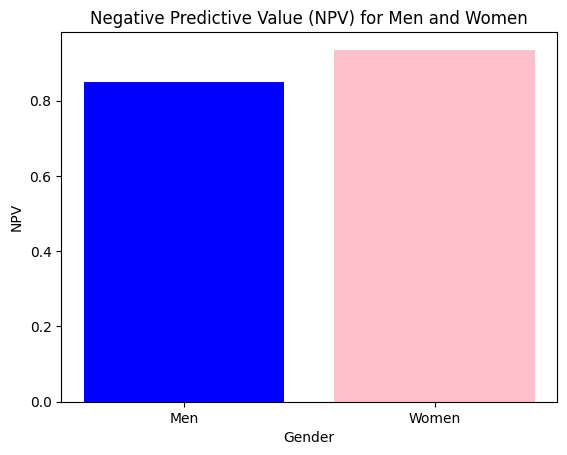

In [ ]:



npv_men = fm_sex_1[5]
npv_women = fm_sex_0[5]


labels = ['Men', 'Women']
values = [npv_men, npv_women]

plt.bar(labels, values, color=['blue', 'pink'])  # You can choose colors as you like
plt.title('Negative Predictive Value (NPV) for Men and Women')
plt.xlabel('Gender')
plt.ylabel('NPV')
plt.show()


In order to reduce the discrepancy as a test reject option classification is then used here as a test to try and see if it can decrease the discrepancy. The Npv men is recalculated using reject option classification and the threshold is changed in order to attempt to have men and womens NPV to be equally accurate. We find we have sucessfully managed to reduce the gap in NPV between men and women however there is a new discpracny as men now have a slightly higher NPV.

In [ ]:

model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)


y_prob = model.predict_proba(X)[:, 1]


npv_men = 0.8482942503589253
npv_women = 0.9352960562451939

thresholds = np.linspace(0, 1, 100)
npv_diff = []

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y, y_pred)
    npv_men_pred = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    npv_women_pred = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    npv_diff.append(np.abs(npv_men_pred - npv_men) + np.abs(npv_women_pred - npv_women))

optimal_threshold = thresholds[np.argmin(npv_diff)]


y_pred_optimal = (y_prob >= optimal_threshold).astype(int)


print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_optimal))
print("Accuracy:", accuracy_score(y, y_pred_optimal))
print("Classification Report:")
print(classification_report(y, y_pred_optimal))


cm_optimal = confusion_matrix(y, y_pred_optimal)


npv_men_optimal = cm_optimal[0, 0] / (cm_optimal[0, 0] + cm_optimal[0, 1]) if (cm_optimal[0, 0] + cm_optimal[0, 1]) > 0 else 0
npv_women_optimal = cm_optimal[1, 0] / (cm_optimal[1, 0] + cm_optimal[1, 1]) if (cm_optimal[1, 0] + cm_optimal[1, 1]) > 0 else 0


print("NPV of Men (After Reject Option Classification):", npv_men_optimal)
print("NPV of Women (After Reject Option Classification):", npv_women_optimal)

Confusion Matrix:
[[22634    20]
 [ 6987   521]]
Accuracy: 0.7676878191101386
Classification Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.87     22654
           1       0.96      0.07      0.13      7508

    accuracy                           0.77     30162
   macro avg       0.86      0.53      0.50     30162
weighted avg       0.81      0.77      0.68     30162

NPV of Men (After Reject Option Classification): 0.9991171537035403
NPV of Women (After Reject Option Classification): 0.9306073521576984


# Conclusion

In this project, our goal was to determine whether or not a person has an income of more than or less than $50,000, depending on the given information. We utilized the 1994 Cencus datset from the UCI Machine Learning Repository to see if there were any disparities particularly between income and sex. We cleaned the dataset by getting rid of unknown values ("?" and n/a values). We also performed data preprocessing to run logistic regression and implemented differential privacy. Some ethical considerations that we have involve historical biases in the data, especially concerning race and sex. This would suggest potential discriminatory outcomes and unfair predictions.

After cleaning our data and completing data preprocessing, we created a logistic regression model to predict if individuals have an income greater than 50K or less than 50K. Our model achieved an overall accuracy of 83.14%. However, it exhibits a trade-off between precision and recall, with higher precision for incomes below 50K but lower recall, and vice versa for incomes above 50K, suggesting potential biases in prediction towards lower incomes.

To start analyzing fairness, we prepare the data by encoding protected features like race and sex into binary variables, with privileged groups assigned 1 and unprivileged groups assigned 0, while the target variable is income (above or below $50K). We then evaluated the model by assessing performance metrics such as precision, recall, and F1-score for both privileged and unprivileged groups, highlighting varying performance across different classes and groups. The final model achieves an 85% overall accuracy, with precision and recall metrics provided for both privileged and unprivileged groups, indicating differences in performance between classes and better performance on the negative class.

After assessing fairness concerns, we tried to mitigate bias by attempting to refit the model. Initially, we checked all attributes identified during the fairness analysis for significant disparities. Subsequently, we refit the model using reject option classification, opting to increase the threshold for men in order to refine the model and enhance the accuracy of rejections. However, while this adjustment led to an improvement in the negative predictive value (NPV) for men, it may have resulted in overfitting, as only the NPV for men increased while the NPV for women remained unchanged.

We faced many challenges but some of the hardest was applying what we learned from the labs and choosing which attributes we wanted to study when it came to choosing which attributes to train the model with. We also wanted a way to test the model and how it weights attributes to race and other protected attributes which lead to our decisision of grouping some protected attributes to see if we could prevent bias in the model. We eventually managed on settling on race and sex in order to protect them in pre and post processing. We had some challenges but overall we mostly managed to mitigate most of the bias the predicitor had in regards to race and sex.

As a result, our predictive model achieved an overall accuracy rate of 83 percent. When assessing bias concerning race and sex, both the primary categories for sex and race, as well as the other sections, exhibited relatively comparable accuracy levels. According to our final step, we successfully mitigated the bias in the two attributes to a significant degree, helping to keep the attributes protected.